Min value of output: -0.008543211035430431
Max value of output: 0.003626961959525943
torch.Size([1, 3, 224, 224])
(112, 112, 3)


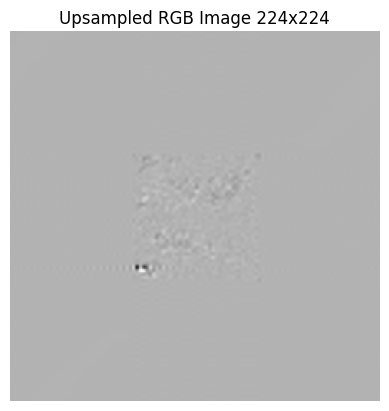

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pydicom
from torchvision.transforms import functional as TF
from torchvision import transforms



class FLC_Pooling(nn.Module):
    # pooling through selecting only the low frequent part in the fourier domain and only using this part to go back into the spatial domain
    # save computations as we do not need to do the downsampling trough conv with stride 2
    def __init__(self, transpose=True):
        self.transpose = transpose
        self.window2d = None
        super(FLC_Pooling, self).__init__()

    def forward(self, x):        
        #x = x.cuda()
        #x = x.to(torch.float32)
        #import ipdb;ipdb.set_trace()
        #if self.window2d is None:
        #    size=x.size(2)
        #    window1d = np.abs(np.hamming(size))
            #window2d = np.sqrt(np.outer(window1d,window1d))
            #window2d = torch.Tensor(window2d)#.cuda()
            #self.window2d = window2d.unsqueeze(0).unsqueeze(0)

        orig_x_size = x.shape
        x = F.pad(x, (x.shape[-1]//1-1, x.shape[-1]//1, x.shape[-2]//1-1, x.shape[-2]//1))


        if self.transpose:
            x = x.transpose(2,3)
        
        low_part = torch.fft.fftshift(torch.fft.fft2(x, norm='forward'))
        #low_part = low_part.cuda()*self.window2d
        '''try:
            #assert low_part.size(2) == self.window2d.size(2)
            #assert low_part.size(3) == self.window2d.size(3)
            #low_part = low_part*self.window2d
        except Exception:
            try:
                assert low_part.size(2) == self.window2d.size(2)
                assert low_part.size(3) == self.window2d.size(3)
                low_part = low_part.cuda()*self.window2d.cuda()
            except Exception:
                #import ipdb;ipdb.set_trace()
                window1d = np.abs(np.hamming(x.shape[2]))
                window1d_2 = np.abs(np.hamming(x.shape[3]))
                window2d = np.sqrt(np.outer(window1d,window1d_2))
                window2d = torch.Tensor(window2d)
                self.window2d = window2d.unsqueeze(0).unsqueeze(0)
                low_part = low_part*self.window2d'''
        
        #low_part = low_part[:,:,int(x.size()[2]/4):int(x.size()[2]/4*3),int(x.size()[3]/4):int(x.size()[3]/4*3)]
        low_part = low_part[:,:,int(orig_x_size[2]/4):int(orig_x_size[2]/4*3),int(orig_x_size[3]/4):int(orig_x_size[3]/4*3)]
        
        return torch.fft.ifft2(torch.fft.ifftshift(low_part), norm='forward').real#.cuda()

# Path to your image
image_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images\ffdc957e-6239-427d-8a54-fdf8ced3a356.dcm"
dicom = pydicom.dcmread(image_path)
image = dicom.pixel_array
image = Image.fromarray(image).convert("RGB")


transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

image_tensor = transform(image).unsqueeze(0)
flc_pooling = FLC_Pooling()
output = flc_pooling(image_tensor)

output_np = output.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
output_np = output_np.astype(np.float32)

print(f"Min value of output: {output_np.min()}")
print(f"Max value of output: {output_np.max()}")

if output_np.max() > 1:
    output_np = (output_np - output_np.min()) / (output_np.max() - output_np.min())  # Rescale to [0, 1]
elif output_np.min() < 0:
    output_np = (output_np - output_np.min()) / (output_np.max() - output_np.min())  # Rescale to [0, 1]


print(image_tensor.shape)
print(output_np.shape)


output_np_scaled = np.clip(output_np, 0, 1) * 255  # Scale to 0-255 if needed
output_np_scaled = output_np_scaled.astype(np.uint8)  # Convert to uint8

output_image = Image.fromarray(output_np_scaled)
upsampled_image = output_image.resize((224, 224), Image.BICUBIC)

upsampled_np = np.array(upsampled_image)
plt.imshow(upsampled_np)
plt.title("Upsampled RGB Image 224x224")
plt.axis('off')
plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pydicom
from torchvision.transforms import functional as TF
from torchvision import transforms



class FLC_Pooling(nn.Module):
    # pooling through selecting only the low frequent part in the fourier domain and only using this part to go back into the spatial domain
    # save computations as we do not need to do the downsampling trough conv with stride 2
    def __init__(self, transpose=True, odd=True):
        self.transpose = transpose
        self.window2d = None
        self.odd = odd
        super(FLC_Pooling, self).__init__()

    def forward(self, x):        
        #x = x.cuda()
        #x = x.to(torch.float32)
        #import ipdb;ipdb.set_trace()
        #if self.window2d is None:
        #    size=x.size(2)
        #    window1d = np.abs(np.hamming(size))
            #window2d = np.sqrt(np.outer(window1d,window1d))
            #window2d = torch.Tensor(window2d)#.cuda()
            #self.window2d = window2d.unsqueeze(0).unsqueeze(0)

        orig_x_size = x.shape
        print("Before padding x: " + str(x.shape))
        #x = F.pad(x, [0, 1, 0, 1])
        print("After padding x: "+ str(x.shape))
        x = F.pad(x, (x.shape[-1]//1+1, x.shape[-1]//1, x.shape[-2]//1+1, x.shape[-2]//1))


        #if self.transpose:
            #x = x.transpose(2,3)
        
        low_part = torch.fft.fftshift(torch.fft.fft2(x, norm='forward'))
        #low_part = low_part.cuda()*self.window2d
        '''try:
            #assert low_part.size(2) == self.window2d.size(2)
            #assert low_part.size(3) == self.window2d.size(3)
            #low_part = low_part*self.window2d
        except Exception:
            try:
                assert low_part.size(2) == self.window2d.size(2)
                assert low_part.size(3) == self.window2d.size(3)
                low_part = low_part.cuda()*self.window2d.cuda()
            except Exception:
                #import ipdb;ipdb.set_trace()
                window1d = np.abs(np.hamming(x.shape[2]))
                window1d_2 = np.abs(np.hamming(x.shape[3]))
                window2d = np.sqrt(np.outer(window1d,window1d_2))
                window2d = torch.Tensor(window2d)
                self.window2d = window2d.unsqueeze(0).unsqueeze(0)
                low_part = low_part*self.window2d'''
        
        #low_part = low_part[:,:,int(x.size()[2]/4):int(x.size()[2]/4*3),int(x.size()[3]/4):int(x.size()[3]/4*3)]
        low_part = low_part[:,:,int((x.shape[2]+1)/4):int((x.shape[2]+1)/4*3),int((x.shape[3]+1)/4):int((x.shape[3]+1)/4*3)]
        
        something = torch.fft.ifft2(torch.fft.ifftshift(low_part), norm='forward').abs()
        print("Before removing padding something: " + str(something.shape))

        if self.odd:
            something = something[:,:, 1:, 1:]
        else:
            something = something[:,:, :-1, :-1]
        print("After removing padding something: " + str(something.shape))

        return something#.cuda()

        #return torch.fft.ifft2(torch.fft.ifftshift(low_part), norm='forward').real#.cuda()


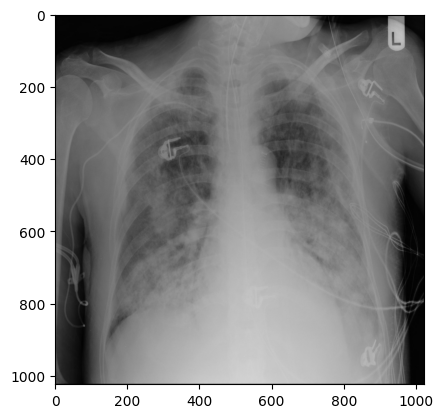

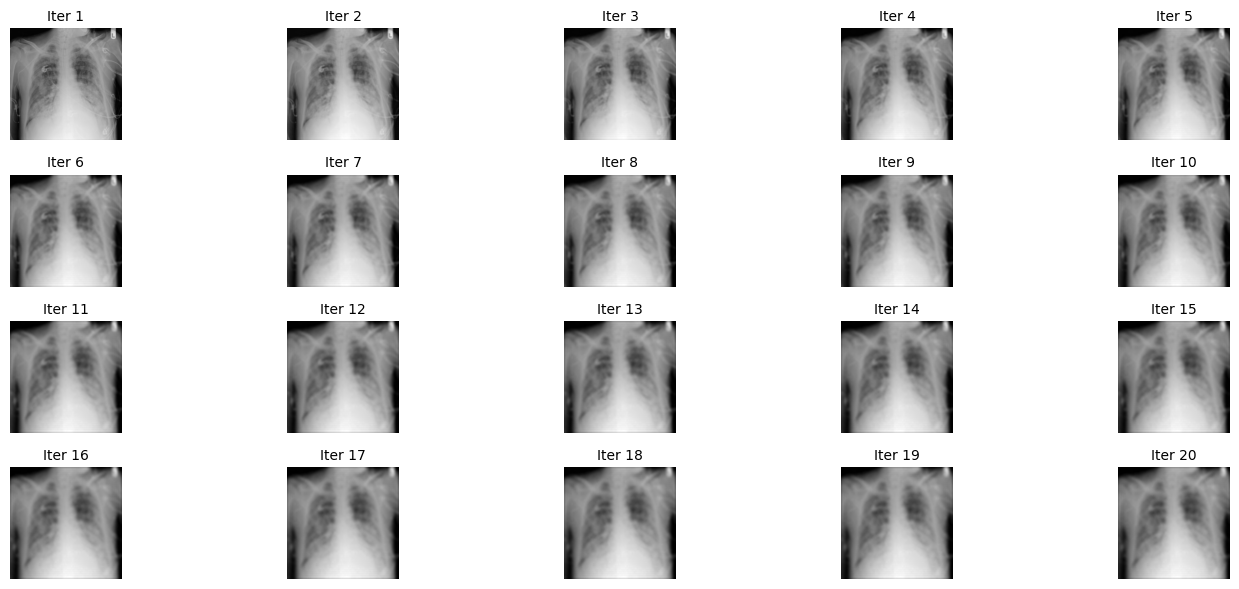

In [10]:
csv_path = r"/pfs/work7/workspace/scratch/ma_mkleinma-thesis/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
image_folder = r"/pfs/work7/workspace/scratch/ma_mkleinma-thesis/rsna-pneumonia-detection-challenge/stage_2_train_images"
splits_path = r"/pfs/work7/workspace/scratch/ma_mkleinma-thesis/training_splits/splits_balanced.pkl"

model_path = r"C:\Users\Admin\Documents\MasterThesis\results\ResNet50_BCos_FLC_HammingWindow_Fix_LowRes\seed_0\pneumonia_detection_model_bcos_trans_bestf1_1_11.pth"
from libraries.bcosconv2d import NormedConv2d
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d


image_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images\fffb2395-8edd-4954-8a89-ffe2fd329be3.dcm"
dicom = pydicom.dcmread(image_path)
image = dicom.pixel_array
image = Image.fromarray(image).convert("RGB")



transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resize image to model's expected input size
    transforms.ToTensor()  # Normalize image
])

class correct_ASAP_padding_large(nn.Module):
    # pooling trough selecting only the low frequent part in the fourier domain and only using this part to go back into the spatial domain
    # save computations as we do not need to do the downsampling trough conv with stride 2
    # using a hamming window to prevent sinc-interpolation artifacts
    def __init__(self):
        self.window2d = None
        super(correct_ASAP_padding_large, self).__init__()

    def forward(self, x):

        x = F.pad(x, (int(x.size(3)/2-1), int(x.size(3)/2), int(x.size(2)/2-1), int(x.size(2)/2)), "constant", 0)
        if not torch.is_tensor(self.window2d):
            window1d = np.abs(np.hamming(x.size(2)))
            #window2d = np.sqrt(np.outer(window1d,window1d))
            window2nd = np.abs(np.hamming(x.size(3)))
            window2d = np.sqrt(np.outer(window1d,window2nd))
            self.window2d = torch.Tensor(window2d)
            del window1d
            del window2d

        low_part = torch.fft.fftshift(torch.fft.fft2(x, norm='forward'))
        low_part = low_part*self.window2d.unsqueeze(0).unsqueeze(0)
        low_part = low_part[:,:,int(x.size()[2]/4):int(x.size()[2]/4*3),int(x.size()[3]/4):int(x.size()[3]/4*3)]

        fc = torch.fft.ifft2(torch.fft.ifftshift(low_part), norm='forward').real
        fc = fc[:,:,int( fc.size(2)/4):int(3*fc.size(2)/4),int(fc.size(3)/4): int(3*fc.size(3)/4)]
        return fc



#flc_pooling = FLC_Pooling()
image_tensor = transform(image).unsqueeze(0)


num_iterations = 20
output_images = []

plt.imshow(image)
plt.show()

current_output = image_tensor
# multiple iterations of adjusting the image and upsampling it
for i in range(num_iterations):
    odd = True if i%2 == 1 else False
    flc_pooling = correct_ASAP_padding_large()
    output = flc_pooling(current_output)
    output_np = output.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    #print(np.max(output_np))
    #print(np.min(output_np))
    output_np = output_np.astype(np.float32)

    output_np = (output_np - output_np.min()) / (output_np.max() - output_np.min() + 1e-8)  
    output_np_scaled = (output_np * 255).astype(np.uint8)    
    
    #downsampled_image = output.resize((112,112), Image.BICUBIC)
    
    output_image_np = Image.fromarray(output_np_scaled)
    upsampled_image = output_image_np.resize((224, 224), Image.BICUBIC)

    output_images.append(np.array(upsampled_image))
    current_output = transform(upsampled_image).unsqueeze(0)
    
    

cols = 5  
rows = (num_iterations + cols - 1) // cols  
fig, axes = plt.subplots(rows, cols, figsize=(15, 6), dpi=100)

for i, ax in enumerate(axes.flat):
    if i < num_iterations:
        ax.imshow(output_images[i])
        ax.set_title(f"Iter {i+1}", fontsize=10)
    ax.axis('off')  # Remove axes for cleaner display

plt.tight_layout()
plt.show()



Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main


(1024, 1024)
torch.Size([6, 224, 224])


C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main\bcos\common.py:152: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


Before padding x: torch.Size([1, 128, 56, 56])
After padding x: torch.Size([1, 128, 57, 57])
Before removing padding something: torch.Size([1, 128, 29, 29])
After removing padding something: torch.Size([1, 128, 28, 28])
Before padding x: torch.Size([1, 512, 56, 56])
After padding x: torch.Size([1, 512, 57, 57])
Before removing padding something: torch.Size([1, 512, 29, 29])
After removing padding something: torch.Size([1, 512, 28, 28])
Before padding x: torch.Size([1, 256, 28, 28])
After padding x: torch.Size([1, 256, 29, 29])
Before removing padding something: torch.Size([1, 256, 15, 15])
After removing padding something: torch.Size([1, 256, 14, 14])
Before padding x: torch.Size([1, 1024, 28, 28])
After padding x: torch.Size([1, 1024, 29, 29])
Before removing padding something: torch.Size([1, 1024, 15, 15])
After removing padding something: torch.Size([1, 1024, 14, 14])
Before padding x: torch.Size([1, 512, 14, 14])
After padding x: torch.Size([1, 512, 15, 15])
Before removing padding

True

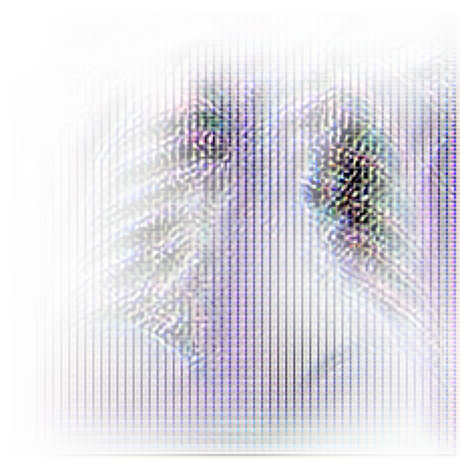

In [4]:
csv_path = r"/pfs/work7/workspace/scratch/ma_mkleinma-thesis/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
image_folder = r"/pfs/work7/workspace/scratch/ma_mkleinma-thesis/rsna-pneumonia-detection-challenge/stage_2_train_images"
splits_path = r"/pfs/work7/workspace/scratch/ma_mkleinma-thesis/training_splits/splits_balanced.pkl"

model_path = r"C:\Users\Admin\Documents\MasterThesis\results\ResNet50_BCos_FLC_HammingWindow_Fix_LowRes\seed_0\pneumonia_detection_model_bcos_trans_bestf1_1_11.pth"
from libraries.bcosconv2d import NormedConv2d
from pooling.flc_bcosconv2d import ModifiedFLCBcosConv2d
import matplotlib.pyplot as plt
import pydicom
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pydicom
from torchvision.transforms import functional as TF
from torchvision import transforms
import cv2


image_path = r"C:\Users\Admin\Documents\rsna-pneumonia-detection-challenge\stage_2_train_images\ffa31ac1-56ef-4f72-98e9-0128274b751f.dcm"
dicom = pydicom.dcmread(image_path)
image = dicom.pixel_array
image = Image.fromarray(image).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to model's expected input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
])



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)

model.layer2[0].conv2 = ModifiedFLCBcosConv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
model.layer2[0].downsample[0] = ModifiedFLCBcosConv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)

model.layer3[0].conv2 = ModifiedFLCBcosConv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
model.layer3[0].downsample[0] = ModifiedFLCBcosConv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)

model.layer4[0].conv2 = ModifiedFLCBcosConv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), b=2, transpose=True)
model.layer4[0].downsample[0] = ModifiedFLCBcosConv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), b=2, transpose=False)    
model.fc.linear = NormedConv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network

state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.eval()


#model.layer2[0].downsample[0].flcpool = nn.MaxPool2d(2,2)
#model.layer3[0].downsample[0].flcpool = nn.MaxPool2d(2,2)
#model.layer4[0].downsample[0].flcpool = nn.MaxPool2d(2,2)

model.to(device)

print(image.size)
image_tensor = model.transform(image)
print(image_tensor.shape)
image_tensor = image_tensor.to(device)

explanation = model.explain(image_tensor.unsqueeze(0))

expl_image = explanation['explanation']
plt.imshow(expl_image)
plt.axis('off')
plt.tight_layout()
print(expl_image.shape)
cv2.imwrite(r"C:\Users\Admin\Pictures\test.png" ,expl_image)



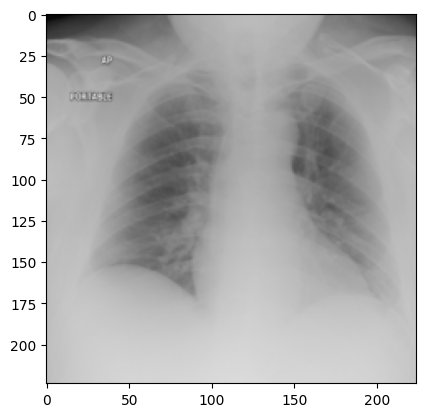

In [5]:
plt.imshow(image_tensor[:3].detach().cpu().permute(1,2,0))


In [6]:
print(model)

BcosResNet(
  (conv1): BcosConv2d(
    B=2,
    (linear): NormedConv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  )
  (pool): AvgPool2d(kernel_size=3, stride=2, padding=1)
  (bn1): BatchNormUncentered2dNoBias(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): BcosConv2d(
        B=2,
        (linear): NormedConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn1): BatchNormUncentered2dNoBias(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): BcosConv2d(
        B=2,
        (linear): NormedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bn2): BatchNormUncentered2dNoBias(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): BcosConv2d(
        B=2,
        (linear): NormedConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn3):